In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

#for json convertion
import ast


import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans

In [4]:
# Load Data Sets
df1 = pd.read_csv('cleanData/cleanChargingDataNoNull.csv')
df2 = pd.read_csv('weather_burbank_airport.csv')

In [5]:
#control if data was loaded
print(df1.head())
print(df2.head())

   Unnamed: 0     id       connectionTime       disconnectTime  \
0        1151  52943  2018-10-09 15:26:40  2018-10-09 19:48:12   
1        1156  53111  2018-10-12 10:07:47  2018-10-12 15:58:22   
2        1157  53138  2018-10-15 06:46:28  2018-10-15 17:43:30   
3        1158  53213  2018-10-16 07:13:50  2018-10-16 15:03:42   
4        1159  53258  2018-10-16 15:29:34  2018-10-16 20:30:34   

      doneChargingTime  kWhDelivered  siteID  spaceID    stationID  userID_x  \
0  2018-10-09 19:28:29        12.034       1  AG-1F01  1-1-193-825     383.0   
1  2018-10-12 14:46:28        14.289       1  AG-1F01  1-1-193-825     335.0   
2  2018-10-15 09:03:25         6.457       1  AG-1F01  1-1-193-825     365.0   
3  2018-10-16 10:11:45         7.416       1  AG-1F01  1-1-193-825     374.0   
4  2018-10-16 18:33:31         9.909       1  AG-1F01  1-1-193-825     467.0   

      parkDuration  WhPerMile  kWhRequested  milesRequested  minutesAvailable  \
0  0 days 04:21:32      400.0        15.2

Feature Engineering to focus on the relevant data for clustering

1. Session Duration (minutes): Time between connectionTime and disconnectTime.
2. Charging Duration (minutes): Time between connectionTime and doneChargingTime.
3. Idle Duration (minutes): Time between doneChargingTime and disconnectTime.
4. Charging Efficiency (kWh per minute): kWhDelivered / Charging Duration.
5. User Inputs: Extract fields from the userInputs JSON object (e.g., kWhRequested, minutesAvailable).


In [6]:
#since the data is in a string-format, there must be a conversion to datetime before performing calculations on it
df1['connectionTime'] = pd.to_datetime(df1['connectionTime'])
df1['disconnectTime'] = pd.to_datetime(df1['disconnectTime'])
df1['doneChargingTime'] = pd.to_datetime(df1['doneChargingTime'])
#calculating the session duration in minutes
df1['session_duration'] = (df1['disconnectTime'] - df1['connectionTime']).dt.total_seconds() / 60
df1['charging_duration'] = (df1['doneChargingTime'] - df1['connectionTime']).dt.total_seconds() / 60
df1['idle_duration'] = (df1['disconnectTime'] - df1['doneChargingTime']).dt.total_seconds() / 60
df1['charging_efficiency'] = df1['kWhDelivered'] / (df1['charging_duration'] / 60)

In [7]:
features = df1[['session_duration', 'charging_duration', 'idle_duration', 'charging_efficiency', 'kWhDelivered']]

print(features.head())

   session_duration  charging_duration  idle_duration  charging_efficiency  \
0        261.533333         241.816667      19.716667             2.985898   
1        350.583333         278.683333      71.900000             3.076395   
2        657.033333         136.950000     520.083333             2.828916   
3        469.866667         177.916667     291.950000             2.500946   
4        301.000000         183.950000     117.050000             3.232074   

   kWhDelivered  
0        12.034  
1        14.289  
2         6.457  
3         7.416  
4         9.909  


Cleaning up the data in "features"

In [8]:
print(features.isnull().sum())  # Check for missing values in each column
print(np.isinf(features).sum())  # Check for infinite values

session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64


In [9]:
# Filter data for each garage
garage_a_df_filter = df1[df1['siteID'] == 1]
garage_b_df_filter = df1[df1['siteID'] == 2]

# Save each garage's data to a separate CSV file
garage_a_df_filter.to_csv('GarageA_data.csv', index=False)
garage_b_df_filter.to_csv('GarageB_data.csv', index=False)

print("CSV files created: 'GarageA_data.csv' and 'GarageB_data.csv'")

CSV files created: 'GarageA_data.csv' and 'GarageB_data.csv'


In [10]:
# Load new Data Sets
garage_a_df = pd.read_csv('GarageA_data.csv')
garage_b_df = pd.read_csv('GarageB_data.csv')

In [11]:
#since the data is in a string-format, there must be a conversion to datetime before performing calculations on it
garage_a_df['connectionTime'] = pd.to_datetime(garage_a_df['connectionTime'])
garage_a_df['disconnectTime'] = pd.to_datetime(garage_a_df['disconnectTime'])
garage_a_df['doneChargingTime'] = pd.to_datetime(garage_a_df['doneChargingTime'])
#calculating the session duration in minutes
garage_a_df['session_duration'] = (garage_a_df['disconnectTime'] - garage_a_df['connectionTime']).dt.total_seconds() / 60
garage_a_df['charging_duration'] = (garage_a_df['doneChargingTime'] - garage_a_df['connectionTime']).dt.total_seconds() / 60
garage_a_df['idle_duration'] = (garage_a_df['disconnectTime'] - garage_a_df['doneChargingTime']).dt.total_seconds() / 60
garage_a_df['charging_efficiency'] = garage_a_df['kWhDelivered'] / (garage_a_df['charging_duration'] / 60)

In [12]:
featuresA = garage_a_df[['session_duration', 'charging_duration', 'idle_duration', 'charging_efficiency', 'kWhDelivered']]

print(featuresA.head())
print(featuresA.isnull().sum())  # Check for missing values in each column
print(np.isinf(featuresA).sum())  # Check for infinite values

   session_duration  charging_duration  idle_duration  charging_efficiency  \
0        261.533333         241.816667      19.716667             2.985898   
1        350.583333         278.683333      71.900000             3.076395   
2        657.033333         136.950000     520.083333             2.828916   
3        469.866667         177.916667     291.950000             2.500946   
4        301.000000         183.950000     117.050000             3.232074   

   kWhDelivered  
0        12.034  
1        14.289  
2         6.457  
3         7.416  
4         9.909  
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64


In [13]:
#since the data is in a string-format, there must be a conversion to datetime before performing calculations on it
garage_b_df['connectionTime'] = pd.to_datetime(garage_b_df['connectionTime'])
garage_b_df['disconnectTime'] = pd.to_datetime(garage_b_df['disconnectTime'])
garage_b_df['doneChargingTime'] = pd.to_datetime(garage_b_df['doneChargingTime'])
#calculating the session duration in minutes
garage_b_df['session_duration'] = (garage_b_df['disconnectTime'] - garage_b_df['connectionTime']).dt.total_seconds() / 60
garage_b_df['charging_duration'] = (garage_b_df['doneChargingTime'] - garage_b_df['connectionTime']).dt.total_seconds() / 60
garage_b_df['idle_duration'] = (garage_b_df['disconnectTime'] - garage_b_df['doneChargingTime']).dt.total_seconds() / 60
garage_b_df['charging_efficiency'] = garage_b_df['kWhDelivered'] / (garage_b_df['charging_duration'] / 60)

In [14]:
featuresB = garage_b_df[['session_duration', 'charging_duration', 'idle_duration', 'charging_efficiency', 'kWhDelivered']]

print(featuresB.head())
print(featuresB.isnull().sum())  # Check for missing values in each column
print(np.isinf(featuresB).sum())  # Check for infinite values

   session_duration  charging_duration  idle_duration  charging_efficiency  \
0        161.633333         150.000000      11.633333             3.387600   
1        236.900000          96.733333     140.166667             3.084562   
2        210.233333          91.083333     119.150000             3.099360   
3        316.566667         226.766667      89.800000             3.209202   
4        126.966667         126.883333       0.083333             3.351740   

   kWhDelivered  
0         8.469  
1         4.973  
2         4.705  
3        12.129  
4         7.088  
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64
session_duration       0
charging_duration      0
idle_duration          0
charging_efficiency    0
kWhDelivered           0
dtype: int64


# Normalizing the data for clustering

In [15]:
scaler = StandardScaler()

#original dataset
scaled_features = scaler.fit_transform(features)

#parking site A
scaled_featuresA = scaler.fit_transform(featuresA)

#parking site B
scaled_featuresB = scaler.fit_transform(featuresB)

# Cluster Analysis

## kMean

### without differentiating between the sites

In [16]:
print(scaled_features.shape)  # Check the number of rows in scaled_features
print(df1.shape)  # Check the number of rows in df1

(37605, 5)
(37605, 23)


In [17]:
scaled_features_cleaned = scaled_features[~np.isinf(features['charging_efficiency']) & features['charging_efficiency'].notna()]

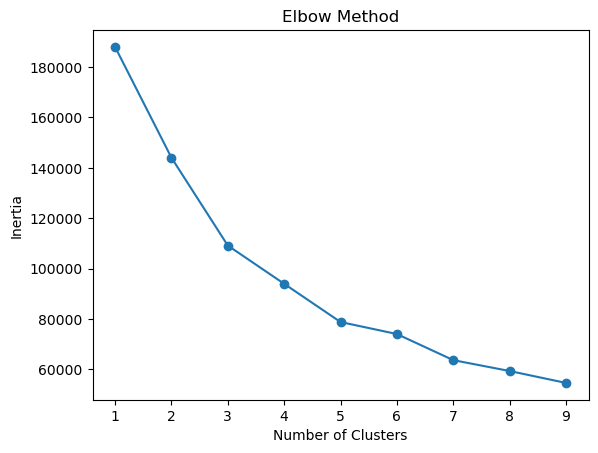

In [18]:
# Determine optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_cleaned)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

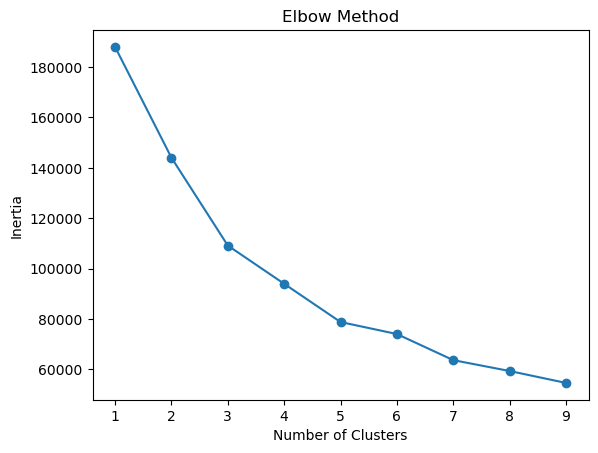

In [19]:
# Determine optimal number of clusters (Elbow Method) k-means ++
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)  # Explicitly using KMeans++
    kmeans.fit(scaled_features_cleaned)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

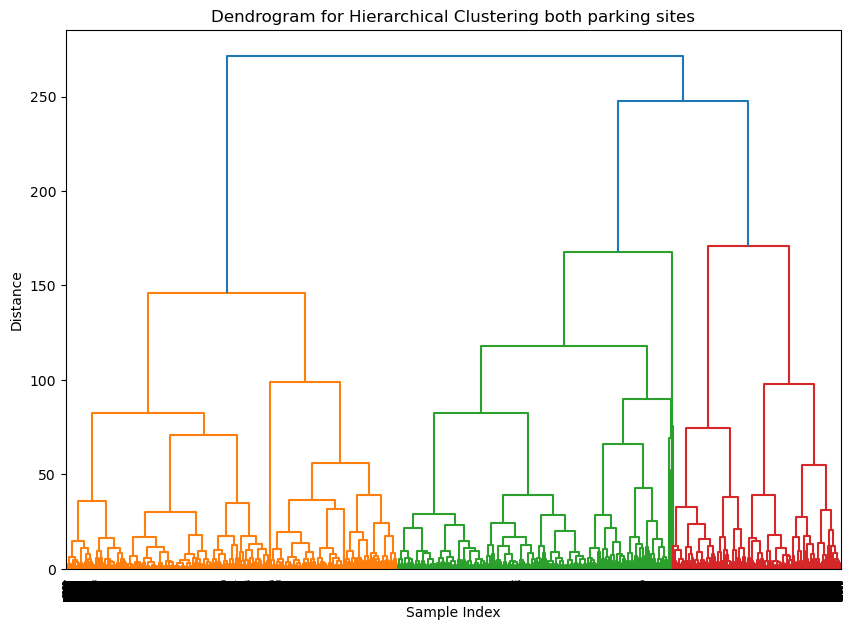

Cluster labels for each data point: [ 8  9 30 ...  6 16  7]


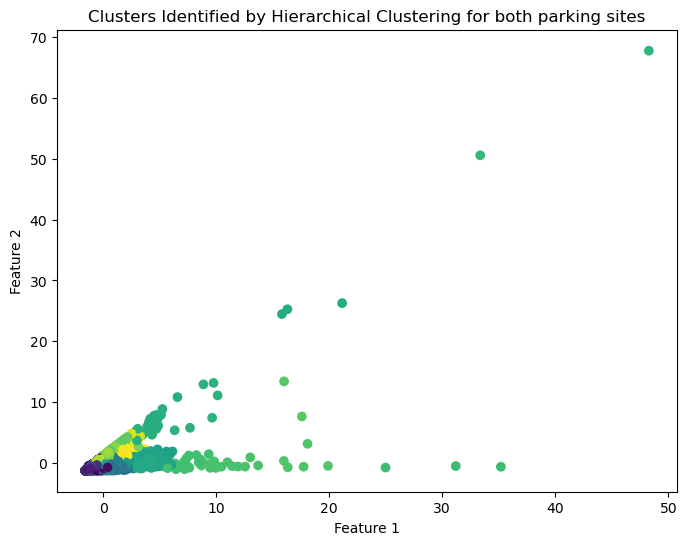

In [17]:
# Perform hierarchical/agglomerative clustering
Z = sch.linkage(scaled_features_cleaned, method='ward')  # 'ward' minimizes the variance of the clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering both parking sites")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


max_d = 15  # Adjust this value to cut the dendrogram at a certain height
clusters = fcluster(Z, max_d, criterion='distance')

# Print the clusters for each data point
print("Cluster labels for each data point:", clusters)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features_cleaned[:, 0], scaled_features_cleaned[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters Identified by Hierarchical Clustering for both parking sites")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


#### Interpretation of the plots

The elbow plot shows a pronounced bend at "number of clusters" = 5. The dendogram also displays 5 clusters, therefore the amount of clusters will be set to 5 in the next step.

In [20]:
# Apply KMeans with optimal clusters
# Apply KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
featuresNew = features.copy()
featuresNew['cluster'] = kmeans.fit_predict(scaled_features)

In [21]:
cluster_summary = featuresNew.groupby('cluster').mean()
print(cluster_summary)

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              518.122268         399.721606     118.400662   
1              562.836196         161.478847     401.357350   
2              520.959654         403.461059     117.498594   
3             4398.839640        1382.065766    3016.773874   
4              181.655482         129.072059      52.583424   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   2.086090     13.162003  
1                   3.244840      8.591137  
2                   5.480710     35.373155  
3                   3.233129     16.387405  
4                   4.251745      9.077120  


#### Visualize data with scatterplot

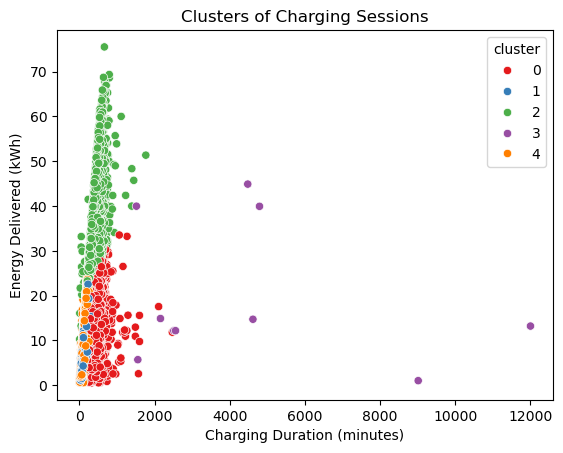

In [22]:
sns.scatterplot(data=featuresNew, x='charging_duration', y='kWhDelivered', hue='cluster', palette='Set1')
plt.title('Clusters of Charging Sessions')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

#### Plot again without outliers

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              191.521869         126.597873      64.923996   
1              261.134964         146.079284     115.055680   
2              588.552823         158.330092     430.222730   
3              525.975295         391.264319     134.710975   
4              547.054164         428.588196     118.465968   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   2.928718      6.008185  
1                   5.799185     13.763263  
2                   2.886850      7.478783  
3                   2.271411     13.811127  
4                   5.349133     37.176719  


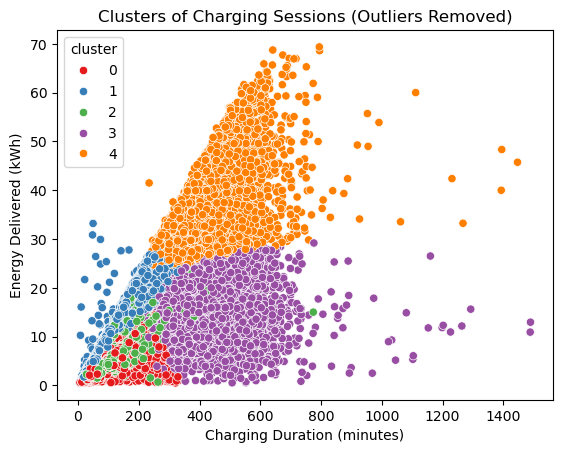

In [23]:
# Define thresholds for filtering outliers
charging_duration_max = 1500  # Maximum acceptable charging duration (minutes)
energy_delivered_max = 70     # Maximum acceptable energy delivered (kWh)

# Filter the dataset to remove outliers and create a copy
filtered_features = features[
    (features['charging_duration'] <= charging_duration_max) &
    (features['kWhDelivered'] <= energy_delivered_max)
].copy()

# Scale the filtered features if needed
scaled_filtered_features = scaler.transform(filtered_features)

# Apply KMeans clustering on the filtered data
filtered_features['cluster'] = kmeans.fit_predict(scaled_filtered_features)

# Group and summarize clusters
cluster_summary = filtered_features.groupby('cluster').mean()
print(cluster_summary)

# Visualize the clusters
sns.scatterplot(
    data=filtered_features,
    x='charging_duration',
    y='kWhDelivered',
    hue='cluster',
    palette='Set1'
)
plt.title('Clusters of Charging Sessions (Outliers Removed)')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

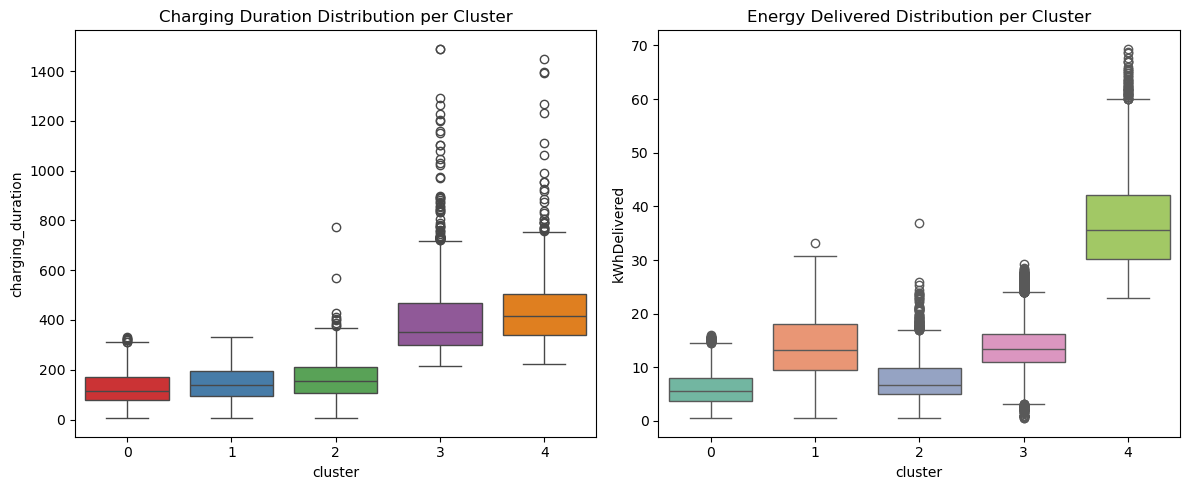

In [55]:
plt.figure(figsize=(12,5))

# Boxplot for Charging Duration
plt.subplot(1,2,1)
sns.boxplot(x=filtered_features['cluster'], y=filtered_features['charging_duration'], hue=filtered_features['cluster'], legend=False, palette="Set1")
plt.title("Charging Duration Distribution per Cluster")

# Boxplot for Energy Delivered
plt.subplot(1,2,2)
sns.boxplot(x=filtered_features['cluster'], y=filtered_features['kWhDelivered'], hue=filtered_features['cluster'], legend=False, palette="Set2")
plt.title("Energy Delivered Distribution per Cluster")

plt.tight_layout()
plt.show()

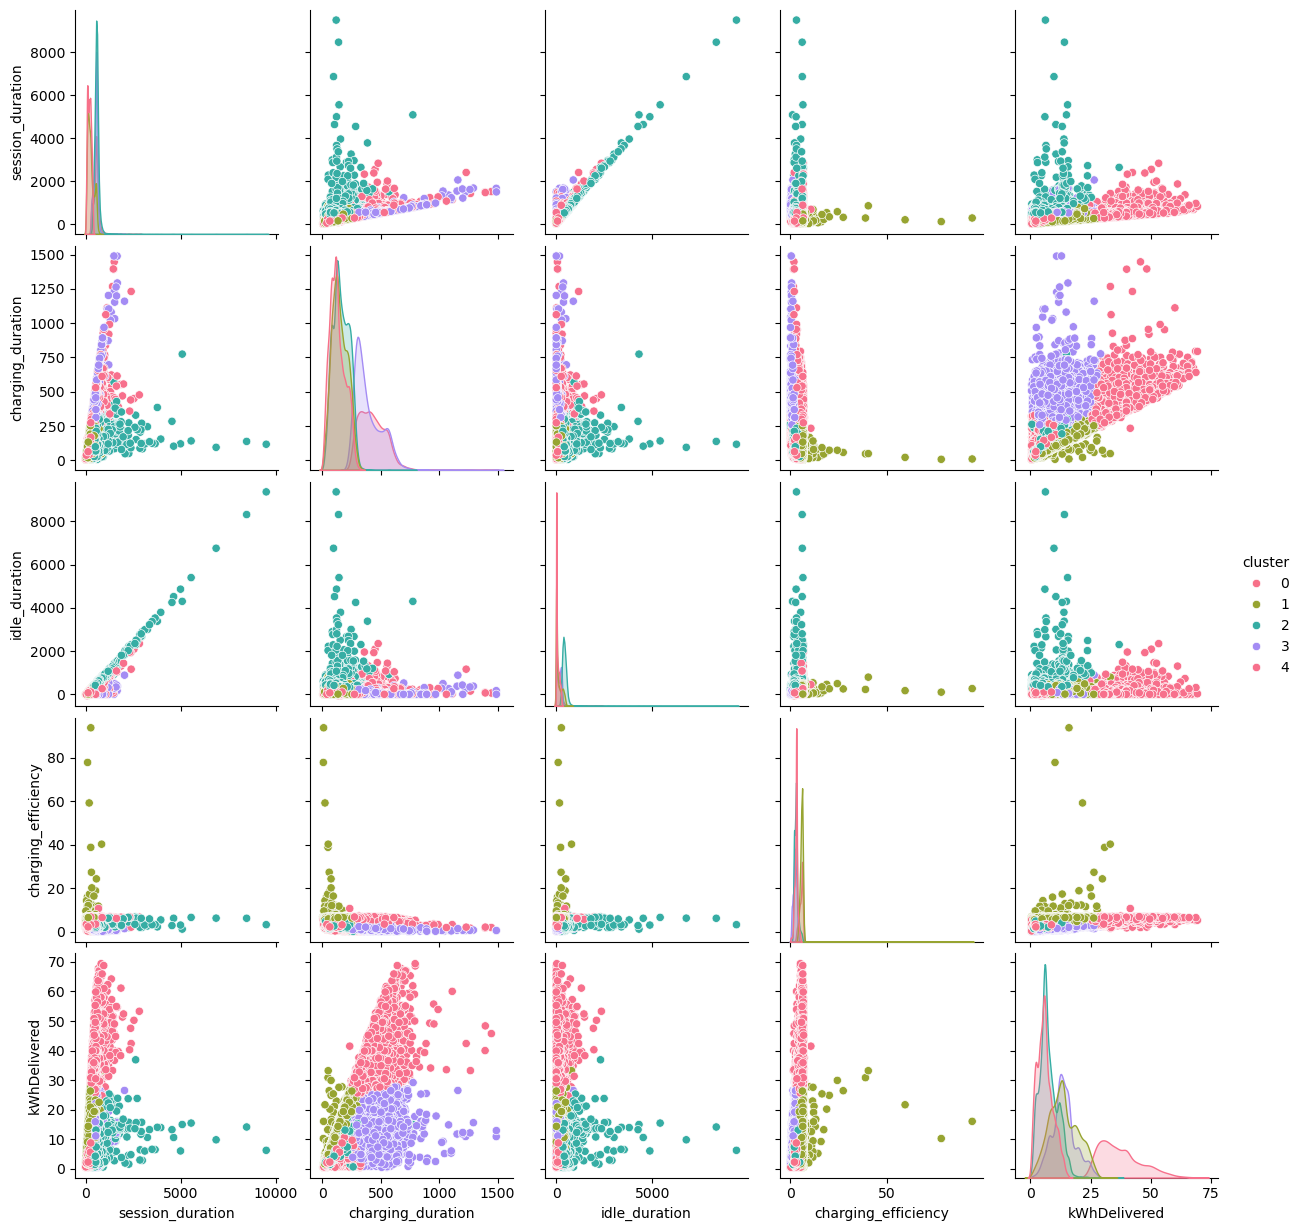

In [25]:
sns.pairplot(filtered_features, hue='cluster', palette='husl')
plt.show()

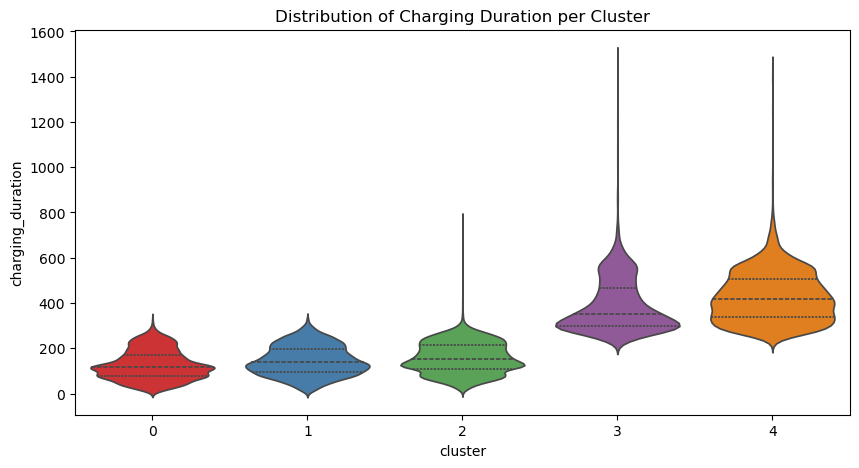

In [63]:
plt.figure(figsize=(10,5))
sns.violinplot(x=filtered_features['cluster'], y=filtered_features['charging_duration'], hue=filtered_features['cluster'], legend=False, palette="Set1", inner="quartile")
plt.title("Distribution of Charging Duration per Cluster")
plt.show()

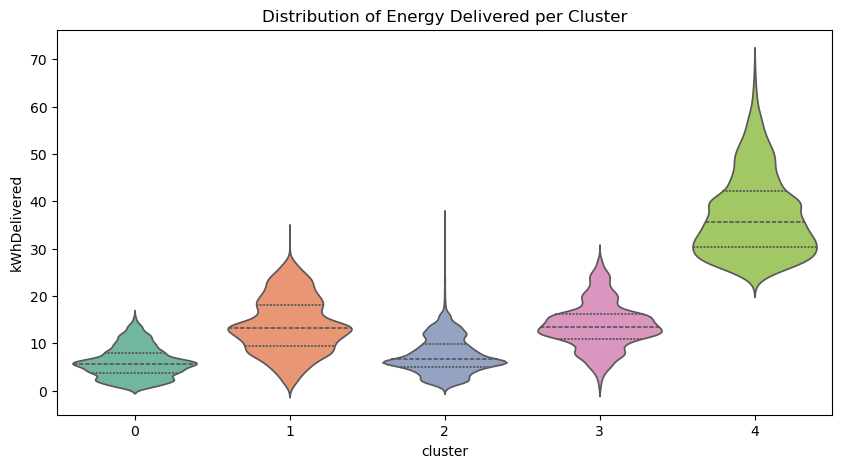

In [62]:
plt.figure(figsize=(10,5))
sns.violinplot(x=filtered_features['cluster'], y=filtered_features['kWhDelivered'], hue=filtered_features['cluster'], legend=False, palette="Set2", inner="quartile")
plt.title("Distribution of Energy Delivered per Cluster")
plt.show()

### For site 1

In [29]:
print(scaled_featuresA.shape)  # Check the number of rows in scaled_featuresA
print(garage_a_df.shape)  # Check the number of rows in garage A

(24787, 5)
(24787, 23)


In [30]:
scaled_features_cleanedA = scaled_featuresA[~np.isinf(garage_a_df['charging_efficiency']) & garage_a_df['charging_efficiency'].notna()]

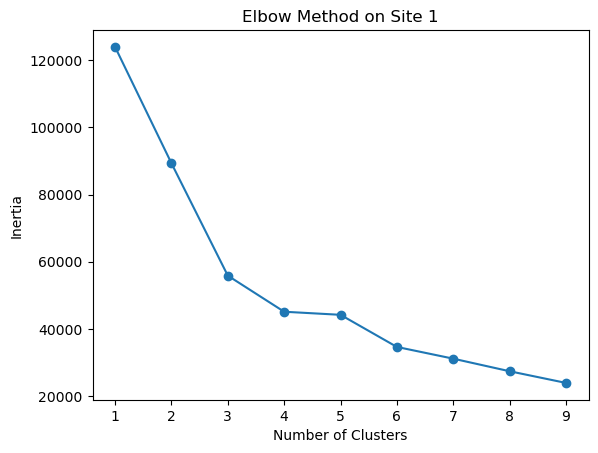

In [31]:
# Determine optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_cleanedA)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method on Site 1')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

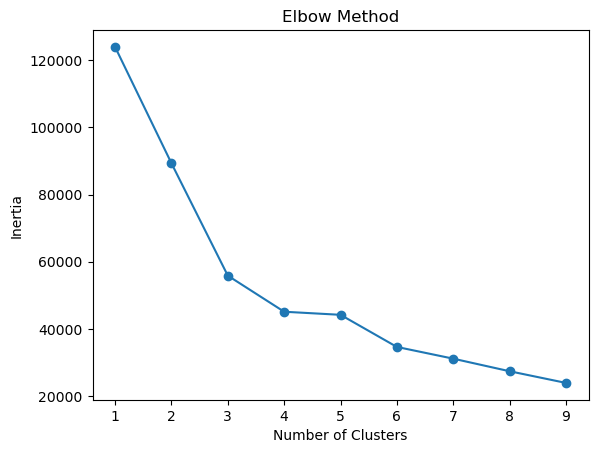

In [32]:
# Determine optimal number of clusters (Elbow Method) k-means ++
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)  # Explicitly using KMeans++
    kmeans.fit(scaled_features_cleanedA)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

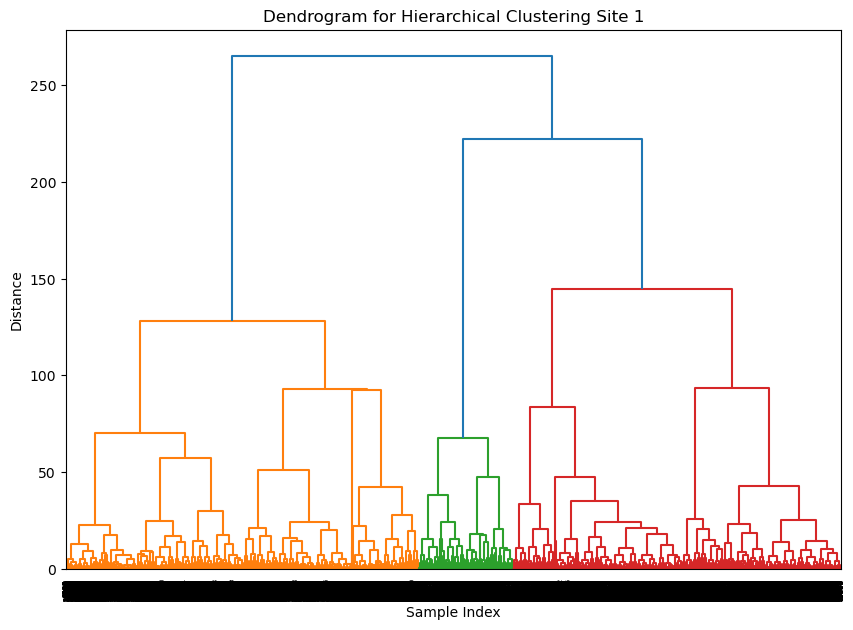

Cluster labels for each data point: [ 5  6 40 ...  3  9 10]


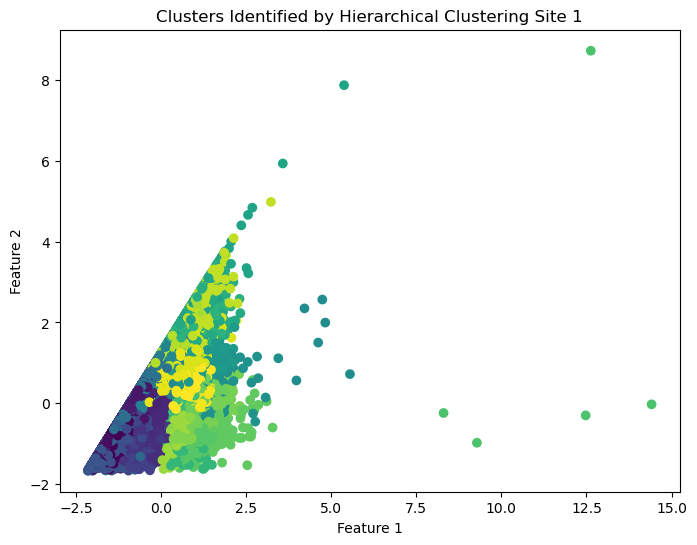

In [25]:
# Perform hierarchical/agglomerative clustering
Z = sch.linkage(scaled_features_cleanedA, method='ward')  # 'ward' minimizes the variance of the clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering Site 1")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


max_d = 15  # Adjust this value to cut the dendrogram at a certain height
clusters = fcluster(Z, max_d, criterion='distance')

# Print the clusters for each data point
print("Cluster labels for each data point:", clusters)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features_cleanedA[:, 0], scaled_features_cleanedA[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters Identified by Hierarchical Clustering Site 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Interpretation of the plot

The elbow plot shows a pronounced bend at "number of clusters" = 3. The dendogram also displays3 clusters, therefore the amount of clusters will be set to 3 in the next step.

In [33]:
# Apply KMeans with optimal clusters
# Apply KMeans clustering with optimal number of clusters
kmeansA = KMeans(n_clusters=3, random_state=42)
garageACopy = featuresA.copy()
garageACopy['cluster'] = kmeansA.fit_predict(scaled_featuresA)

In [34]:
cluster_summaryA = garageACopy.groupby('cluster').mean()
print(cluster_summaryA)

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              567.763708         223.830318     343.933389   
1              542.659963         458.360586      84.299377   
2              207.251190         157.764892      49.486299   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   2.899626     10.256781  
1                   4.333265     31.164536  
2                   4.107949     10.479681  


#### Visualize data with scatterplot

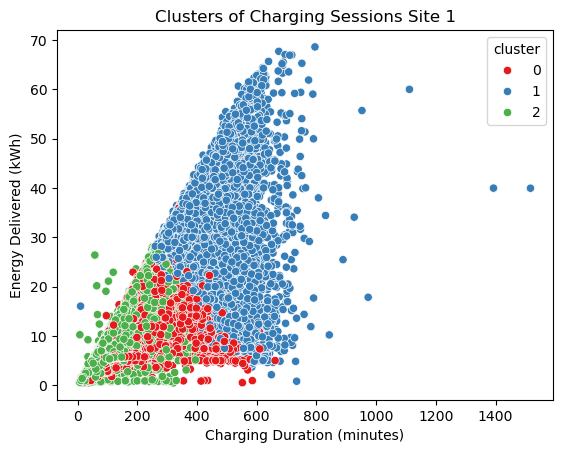

In [35]:
sns.scatterplot(data=garageACopy, x='charging_duration', y='kWhDelivered', hue='cluster', palette='Set1')
plt.title('Clusters of Charging Sessions Site 1')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              550.007021         258.062927     291.944094   
1              517.038295         411.221656     105.816639   
2              207.726411         144.557237      63.169174   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   2.541964     10.071460  
1                   5.189060     34.110217  
2                   4.304354     10.222241  


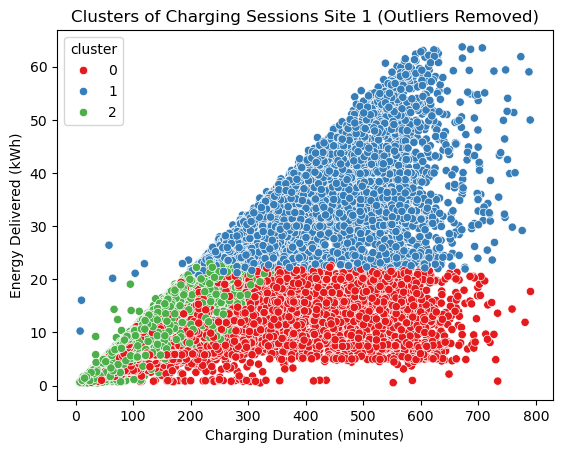

In [36]:
# Define thresholds for filtering outliers
charging_duration_max = 800  # Maximum acceptable charging duration (minutes)
energy_delivered_max = 64     # Maximum acceptable energy delivered (kWh)

# Filter the dataset to remove outliers and create a copy
filtered_featuresA = featuresA[
    (featuresA['charging_duration'] <= charging_duration_max) &
    (featuresA['kWhDelivered'] <= energy_delivered_max)
].copy()

# Scale the filtered features if needed
scaled_filtered_featuresA = scaler.transform(filtered_featuresA)

# Apply KMeans clustering on the filtered data
filtered_featuresA['cluster'] = kmeansA.fit_predict(scaled_filtered_featuresA)

# Group and summarize clusters
cluster_summaryA = filtered_featuresA.groupby('cluster').mean()
print(cluster_summaryA)

# Visualize the clusters
sns.scatterplot(
    data=filtered_featuresA,
    x='charging_duration',
    y='kWhDelivered',
    hue='cluster',
    palette='Set1'
)
plt.title('Clusters of Charging Sessions Site 1 (Outliers Removed)')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

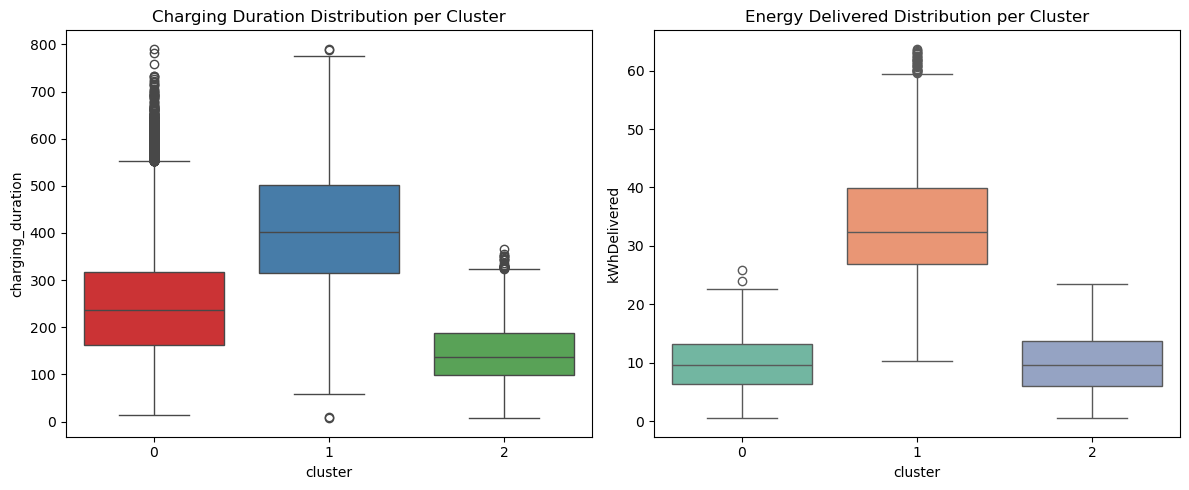

In [56]:
plt.figure(figsize=(12,5))

# Boxplot for Charging Duration
plt.subplot(1,2,1)
sns.boxplot(x=filtered_featuresA['cluster'], y=filtered_featuresA['charging_duration'], hue=filtered_featuresA['cluster'], legend=False, palette="Set1")
plt.title("Charging Duration Distribution per Cluster")

# Boxplot for Energy Delivered
plt.subplot(1,2,2)
sns.boxplot(x=filtered_featuresA['cluster'], y=filtered_featuresA['kWhDelivered'], hue=filtered_featuresA['cluster'], legend=False, palette="Set2")
plt.title("Energy Delivered Distribution per Cluster")

plt.tight_layout()
plt.show()

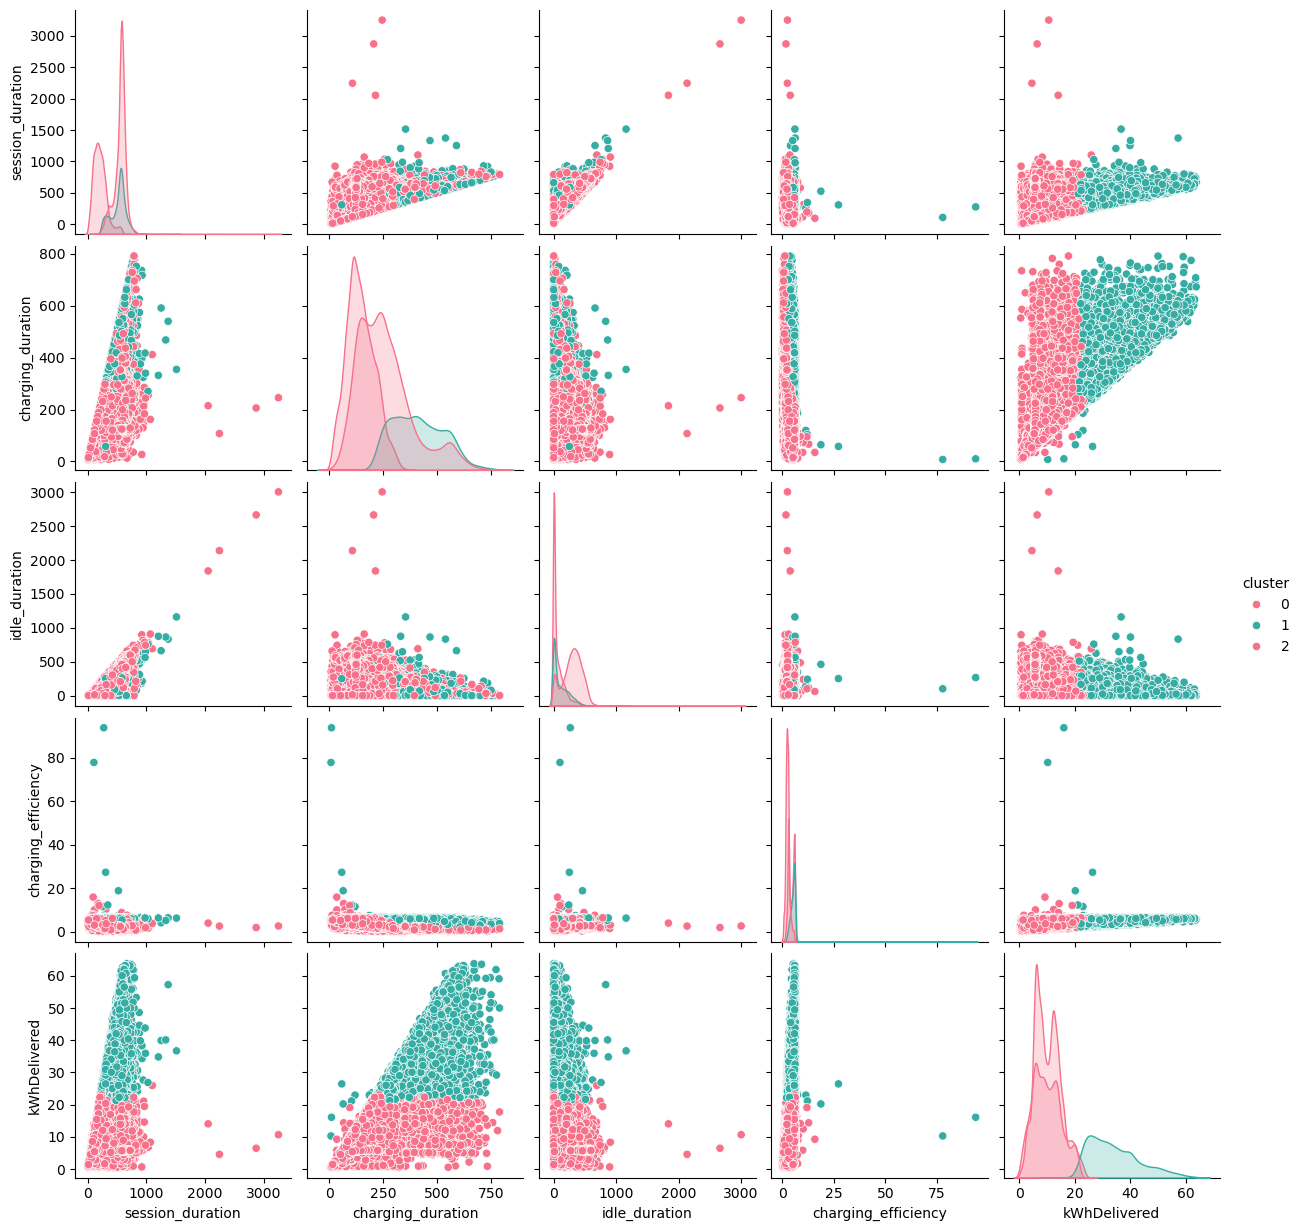

In [39]:
sns.pairplot(filtered_featuresA, hue='cluster', palette='husl')
plt.show()

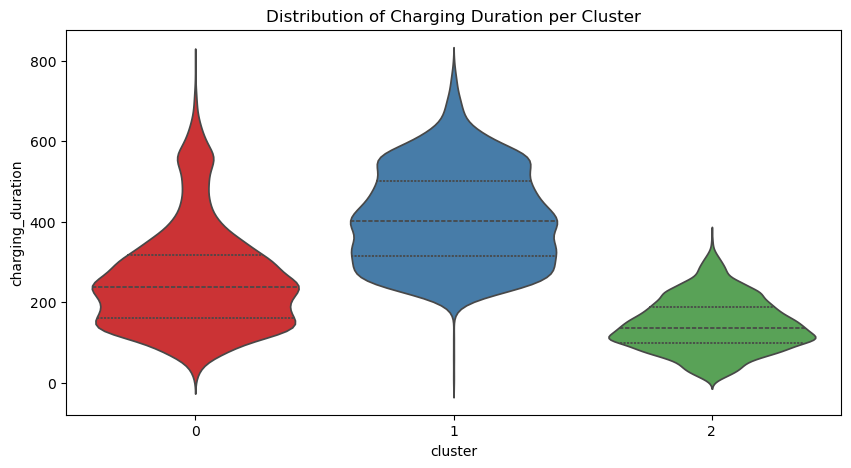

In [61]:
plt.figure(figsize=(10,5))
sns.violinplot(x=filtered_featuresA['cluster'], y=filtered_featuresA['charging_duration'], hue=filtered_featuresA['cluster'], legend=False, palette="Set1", inner="quartile")
plt.title("Distribution of Charging Duration per Cluster")
plt.show()

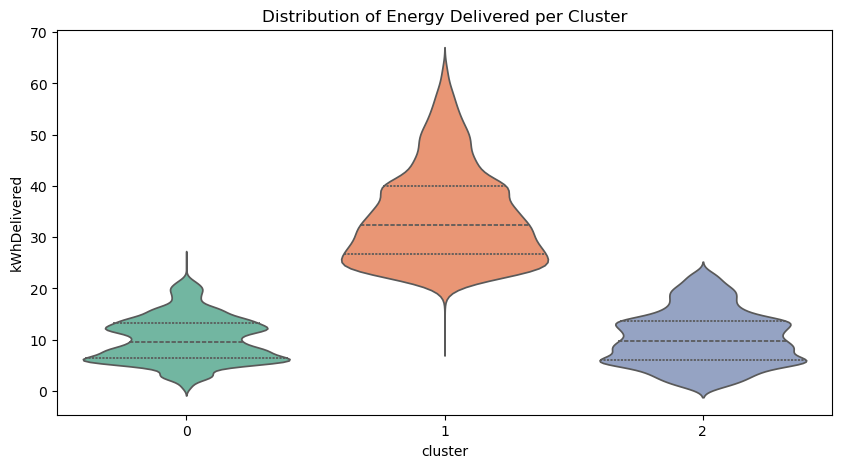

In [60]:
plt.figure(figsize=(10,5))
sns.violinplot(x=filtered_featuresA['cluster'], y=filtered_featuresA['kWhDelivered'], hue=filtered_featuresA['cluster'], legend=False, palette="Set2", inner="quartile")
plt.title("Distribution of Energy Delivered per Cluster")
plt.show()

### For site 2

In [42]:
print(scaled_featuresB.shape)  # Check the number of rows in scaled_featuresB
print(garage_b_df.shape)  # Check the number of rows in garage B

(12818, 5)
(12818, 23)


In [43]:
scaled_features_cleanedB = scaled_featuresB[~np.isinf(garage_b_df['charging_efficiency']) & garage_b_df['charging_efficiency'].notna()]

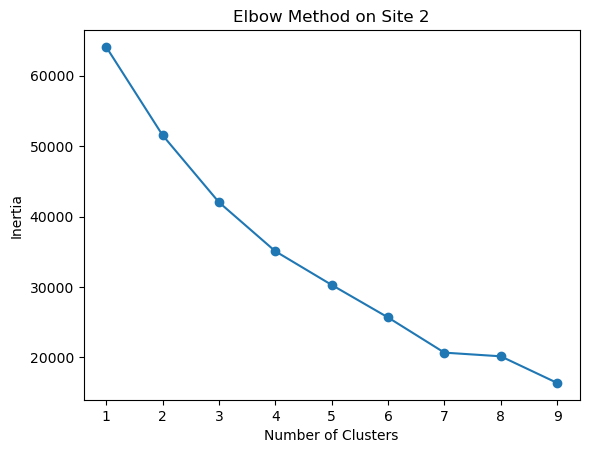

In [44]:
# Determine optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_cleanedB)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method on Site 2')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

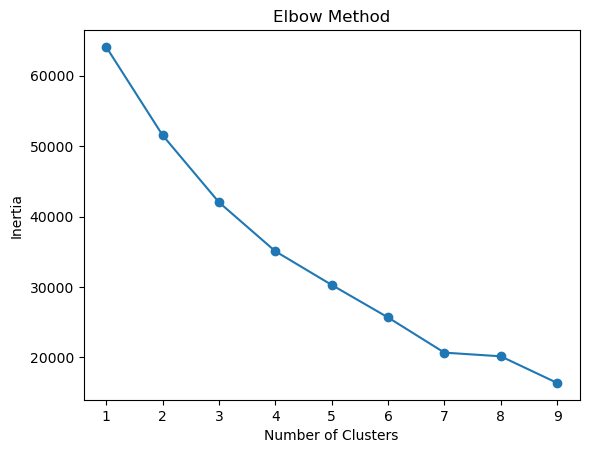

In [45]:
# Determine optimal number of clusters (Elbow Method) k-means ++
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)  # Explicitly using KMeans++
    kmeans.fit(scaled_features_cleanedB)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

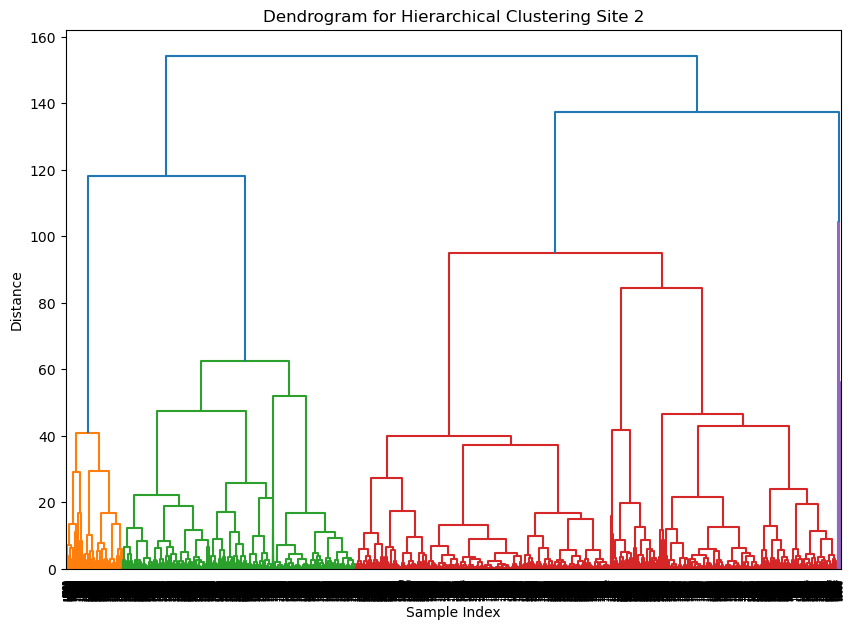

Cluster labels for each data point: [19 23 23 ... 20 15 20]


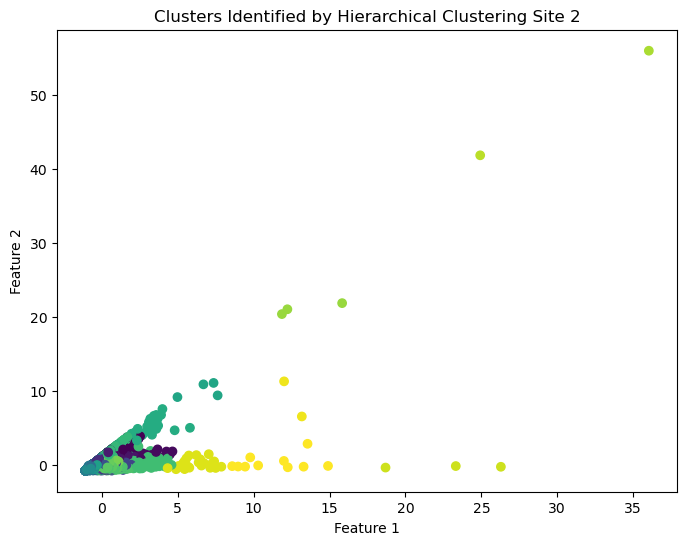

In [33]:
# Perform hierarchical/agglomerative clustering
Z = sch.linkage(scaled_features_cleanedB, method='ward')  # 'ward' minimizes the variance of the clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering Site 2")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


max_d = 15  # Adjust this value to cut the dendrogram at a certain height
clusters = fcluster(Z, max_d, criterion='distance')

# Print the clusters for each data point
print("Cluster labels for each data point:", clusters)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features_cleanedB[:, 0], scaled_features_cleanedB[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters Identified by Hierarchical Clustering Site 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Interpretation of the plot

The plot shows a pronounced bend at "number of clusters" = 7. The dendogram displays 4 clusters, through trial and error the number of clusters is set to 4

In [46]:
# Apply KMeans with optimal clusters
# Apply KMeans clustering with optimal number of clusters
kmeansB = KMeans(n_clusters=4, random_state=42)
garageBCopy = featuresB.copy()
garageBCopy['cluster'] = kmeansB.fit_predict(scaled_featuresB)

In [47]:
cluster_summaryB = garageBCopy.groupby('cluster').mean()
print(cluster_summaryB)

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              514.508177         196.321320     318.186857   
1              544.151853         363.889456     180.262397   
2             4581.790909        1476.292424    3105.498485   
3              195.561704         108.084135      87.477569   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   2.672290      7.472736  
1                   5.808475     32.518198  
2                   3.238613     15.122424  
3                   4.665588      8.375807  


#### Visualize data with scatterplot

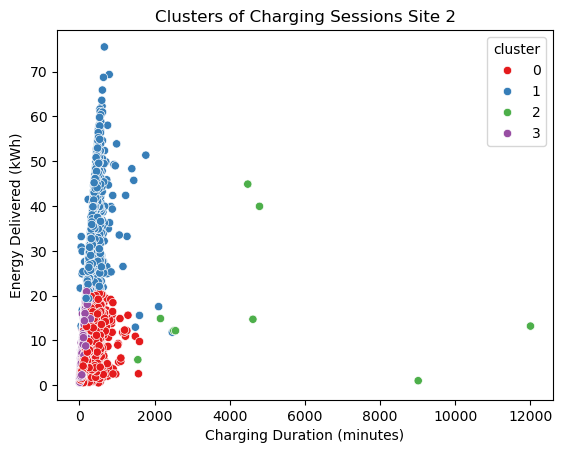

In [48]:
sns.scatterplot(data=garageBCopy, x='charging_duration', y='kWhDelivered', hue='cluster', palette='Set1')
plt.title('Clusters of Charging Sessions Site 2')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

         session_duration  charging_duration  idle_duration  \
cluster                                                       
0              506.059996         192.651959     313.408037   
1              193.512121         107.050033      86.462089   
2             3465.897297         208.205405    3257.691892   
3              524.170595         348.840452     175.330143   

         charging_efficiency  kWhDelivered  
cluster                                     
0                   2.670979      7.409603  
1                   4.677864      8.309817  
2                   4.590009     16.073838  
3                   5.828328     31.929132  


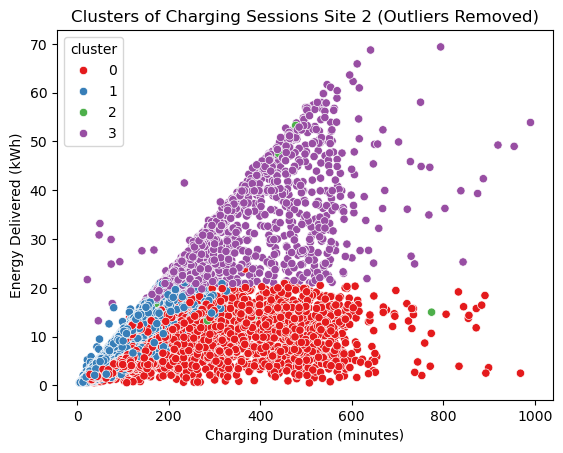

In [49]:
# Define thresholds for filtering outliers
charging_duration_max = 1000  # Maximum acceptable charging duration (minutes)
energy_delivered_max = 70     # Maximum acceptable energy delivered (kWh)

# Filter the dataset to remove outliers and create a copy
filtered_featuresB = featuresB[
    (featuresB['charging_duration'] <= charging_duration_max) &
    (featuresB['kWhDelivered'] <= energy_delivered_max)
].copy()

# Scale the filtered features if needed
scaled_filtered_featuresB = scaler.transform(filtered_featuresB)

# Apply KMeans clustering on the filtered data
filtered_featuresB['cluster'] = kmeansB.fit_predict(scaled_filtered_featuresB)

# Group and summarize clusters
cluster_summaryB = filtered_featuresB.groupby('cluster').mean()
print(cluster_summaryB)

# Visualize the clusters
sns.scatterplot(
    data=filtered_featuresB,
    x='charging_duration',
    y='kWhDelivered',
    hue='cluster',
    palette='Set1'
)
plt.title('Clusters of Charging Sessions Site 2 (Outliers Removed)')
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Energy Delivered (kWh)')
plt.show()

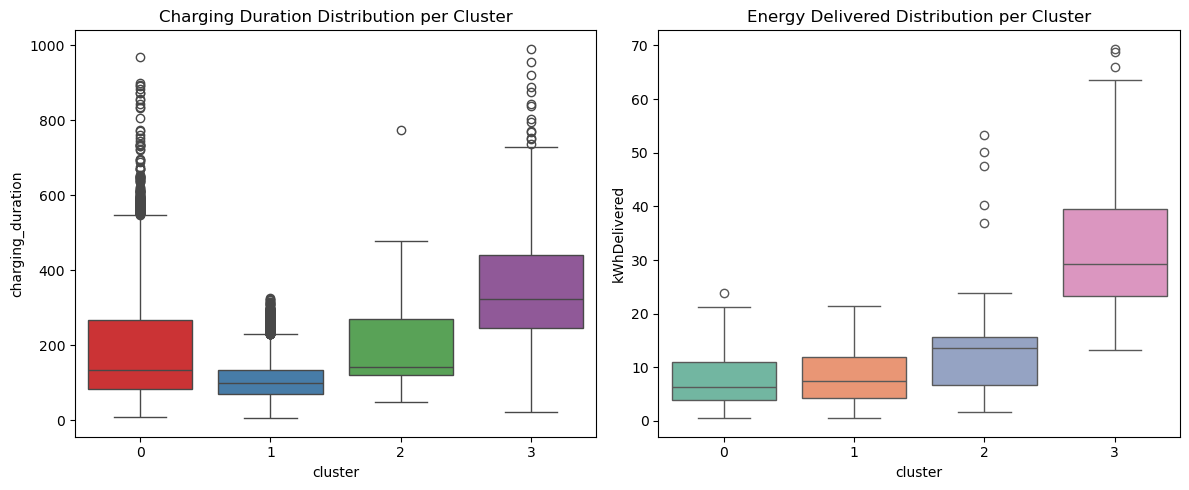

In [57]:
plt.figure(figsize=(12,5))

# Boxplot for Charging Duration
plt.subplot(1,2,1)
sns.boxplot(x=filtered_featuresB['cluster'], y=filtered_featuresB['charging_duration'],hue=filtered_featuresB['cluster'], legend=False, palette="Set1")
plt.title("Charging Duration Distribution per Cluster")

# Boxplot for Energy Delivered
plt.subplot(1,2,2)
sns.boxplot(x=filtered_featuresB['cluster'], y=filtered_featuresB['kWhDelivered'], hue=filtered_featuresB['cluster'], legend=False, palette="Set2")
plt.title("Energy Delivered Distribution per Cluster")

plt.tight_layout()
plt.show()

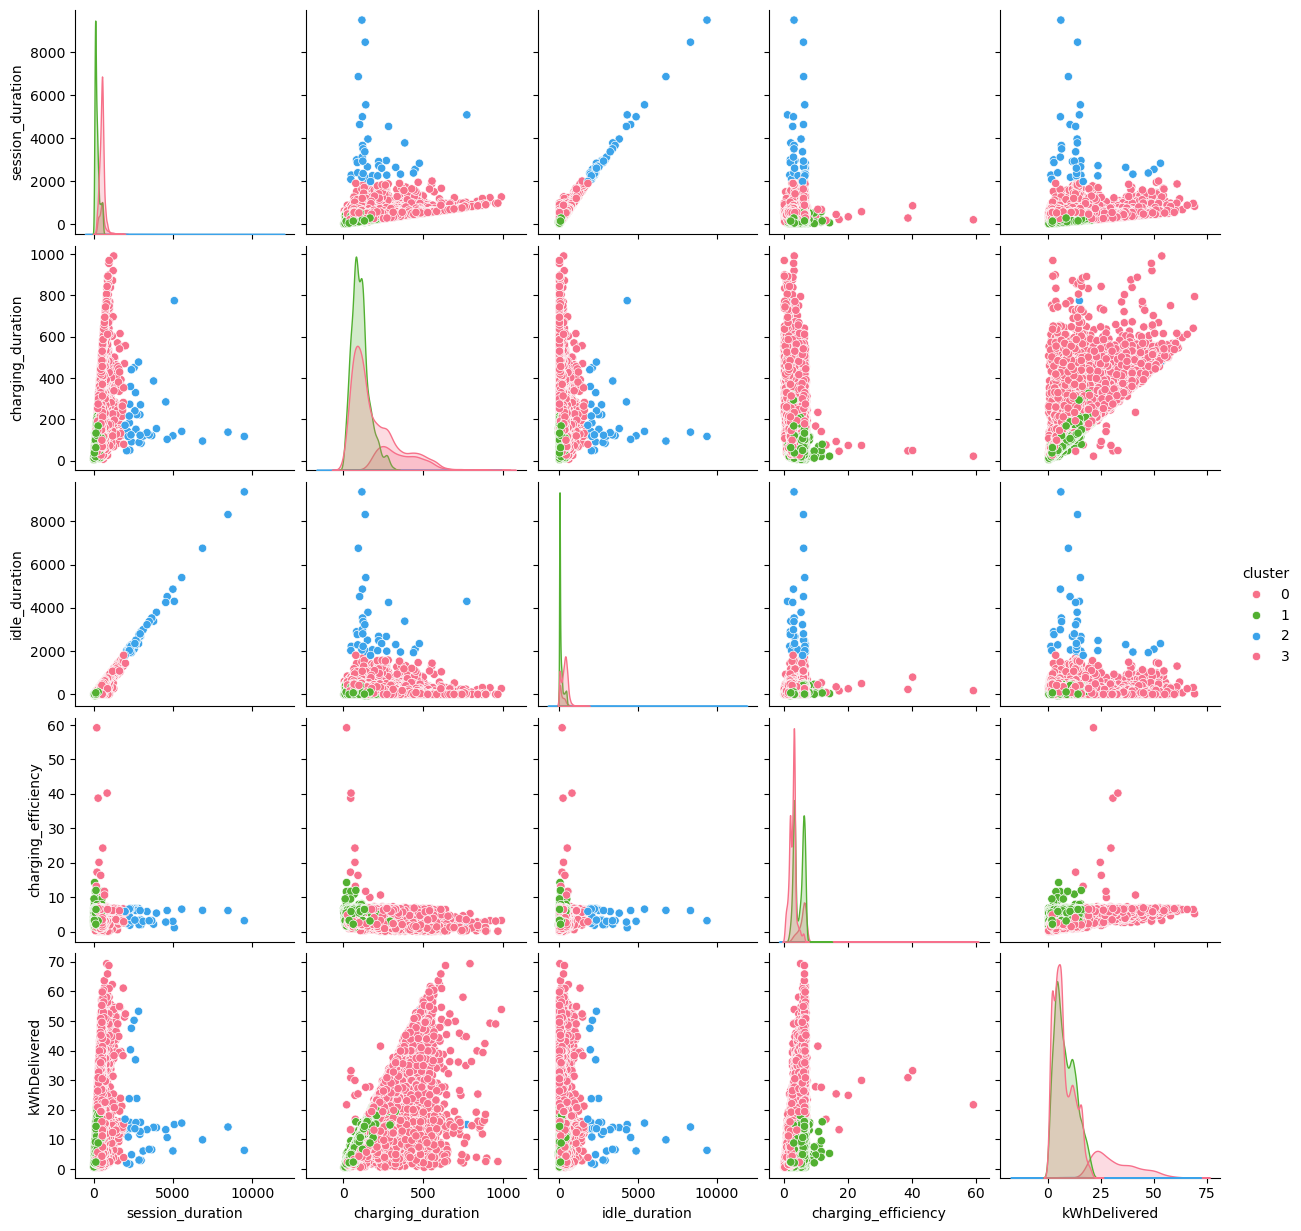

In [52]:
sns.pairplot(filtered_featuresB, hue='cluster', palette='husl')
plt.show()

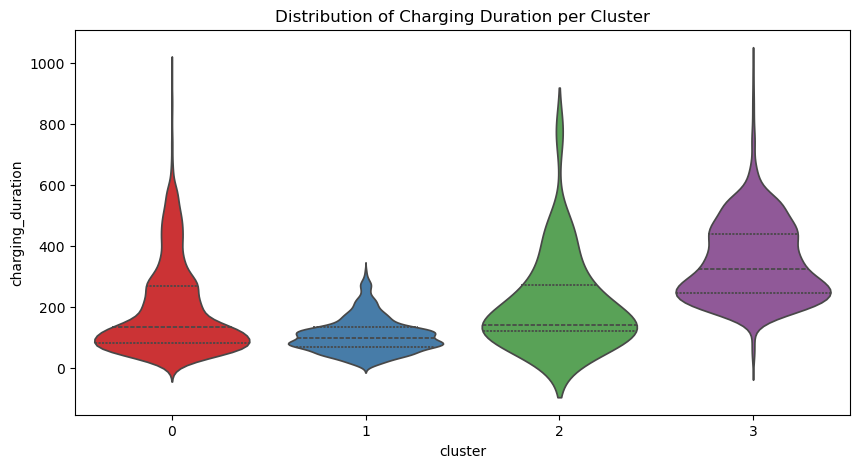

In [58]:
plt.figure(figsize=(10,5))
sns.violinplot(x=filtered_featuresB['cluster'], y=filtered_featuresB['charging_duration'], hue=filtered_featuresB['cluster'], legend=False,palette="Set1", inner="quartile")
plt.title("Distribution of Charging Duration per Cluster")
plt.show()

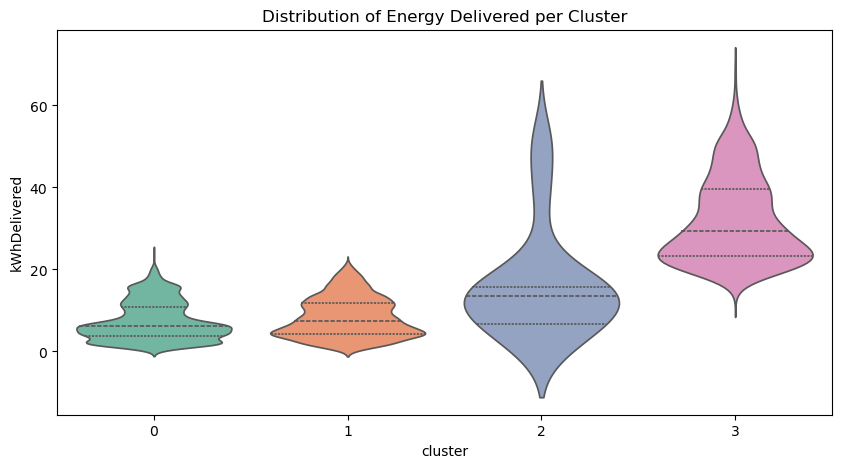

In [59]:
plt.figure(figsize=(10,5))
sns.violinplot(x=filtered_featuresB['cluster'], y=filtered_featuresB['kWhDelivered'], hue=filtered_featuresB['cluster'], legend=False, palette="Set2", inner="quartile")
plt.title("Distribution of Energy Delivered per Cluster")
plt.show()